Below is the code to create all the different loose primes. This was used to to create a dictionary of all the recomended looseprime points and run on run 2 data to see which would work the best so we can choose one to use on further data sets.

In [3]:
##### Code to create different looseprimes

import numpy as np

# ---- 1) Bit positions from egammaPIDdefs.h (only the ones we need here) ----
BIT = {
    "ClusterEtaRange_Photon":         0,   # (sometimes included in PhotonLoose)
    "ClusterHadronicLeakage_Photon": 10,   # Rhad
    "ClusterMiddleEnergy_Photon":    11,   # E277
    "ClusterMiddleEratio37_Photon":  12,   # Reta (common)
    "ClusterMiddleEratio33_Photon":  13,   # Rphi
    "ClusterMiddleWidth_Photon":     14,   # Weta2
    "ClusterStripsEratio_Photon":    15,   # f1 (called Eratio)
    "ClusterStripsDeltaEmax2_Photon":16,   # DeltaEmax2
    "ClusterStripsDeltaE_Photon":    17,   # DeltaE
    "ClusterStripsWtot_Photon":      18,   # Wstot
    "ClusterStripsDEmaxs1_Photon":   21,   # DEmaxs1
    "TrackMatchEoverP_Photon":       22,   # (not usually used for photons)
    # there are more bits defined in the header; add if you need them
}

def mask_of(names):
    """Build a bit mask from a list of bit-name strings."""
    m = 0
    for name in names:
        m |= (1 << BIT[name])
    return m

# Base PhotonLoose mask (Run-2: Rhad, E277, Reta, Weta2, f1) ----
def photon_loose_mask():
    names = [
        "ClusterHadronicLeakage_Photon",  # 10 = Rhad
        "ClusterMiddleEnergy_Photon",     # 11 = E277
        "ClusterMiddleEratio37_Photon",   # 12 = Reta
        "ClusterMiddleWidth_Photon",      # 14 = Weta2
        "ClusterStripsEratio_Photon",     # 15 = f1 (called eratio)
        #"ClusterMiddleEratio33_Photon"    # 13 = Rphi
    ]
    
    return mask_of(names)

# ---- 3) LoosePrime variants (compose from PhotonLoose + extra strips bits) ----
def build_looseprime_masks():
    PL = photon_loose_mask()

    # Convenience aliases
    DEmx2      = "ClusterStripsDeltaEmax2_Photon"
    DeltaE     = "ClusterStripsDeltaE_Photon"
    Wstot      = "ClusterStripsWtot_Photon"
    DEmaxs1    = "ClusterStripsDEmaxs1_Photon"

    masks = {}

    # LoosePrime2: PhotonLoose + {DeltaEmax2, DeltaE, DEmaxs1, Wstot}
    masks["LoosePrime2"] = PL | mask_of([DEmx2, DeltaE, DEmaxs1, Wstot])

    # LoosePrime3: PhotonLoose + {DeltaEmax2, DEmaxs1, Wstot}
    masks["LoosePrime3"] = PL | mask_of([DEmx2, DEmaxs1 , Wstot])

    # LoosePrime4: PhotonLoose + {DeltaEmax2, Wstot}
    masks["LoosePrime4"] = PL | mask_of([DEmx2, Wstot])

    # LoosePrime4a: PhotonLoose + {DeltaEmax2, DEmaxs1}
    masks["LoosePrime4a"] = PL | mask_of([DEmx2, DEmaxs1])

    # LoosePrime5: PhotonLoose + {DeltaEmax2}
    masks["LoosePrime5"] = PL | mask_of([DEmx2])

    masks["Run1"]=0x45fc01

    return masks

# Check to see if photon passes specific mask
def passes(mask, isEM):
    """Return boolean array: True if photon passes the 'LoosePrimeX' mask."""
    return (isEM & mask) == 0


Below is the code used to calculate the ABCD values and find the purity of a dataset. This was used on mc data to validate this method and fix the purities and get thm closer to the actual purities.

In [9]:
import numpy as np
import uproot
import math

FILE = "/data/mhance/SUSY/ntuples/v3.1/output_Znunu_CVetoBVeto_mc20.root"
BRANCHES = [
    "ph_pt", "ph_eta", "ph_topoetcone20", "ph_topoetcone40", "ph_ptcone20",
    "ph_select_tightID", "ph_truthprompt", "ph_isEM",
    "met_met", "jet_cleanTightBad_prod", "j1_pt", "mindPhiJetMet",
    "nBTagJets", "nElectrons", "nMuons", "weight_total", "ph_select_hybridCOIso"
]

with uproot.open(FILE) as f:
    arr = f["picontuple"].arrays(BRANCHES, library="np")

# Scalars/arrays we’ll use
pt      = arr["ph_pt"].astype(float)
eta     = arr["ph_eta"].astype(float)
topo20  = arr["ph_topoetcone20"].astype(float)
topo40  = arr["ph_topoetcone40"].astype(float)
ptc20   = arr["ph_ptcone20"].astype(float)
tight   = (arr["ph_select_tightID"] == 1)
prompt  = (arr["ph_truthprompt"]   == 1)
isEM    = arr["ph_isEM"].astype(np.uint32)
w       = arr["weight_total"].astype(float)

met_met            = arr["met_met"].astype(float)
jet_cleanTightBad  = arr["jet_cleanTightBad_prod"].astype(np.int32)
j1_pt              = arr["j1_pt"].astype(float)
mindPhiJetMet      = arr["mindPhiJetMet"].astype(float)
nBTagJets          = arr["nBTagJets"].astype(np.int32)
nElectrons         = arr["nElectrons"].astype(np.int32)
nMuons             = arr["nMuons"].astype(np.int32)

# ── TOTAL mask for event selection ────────────────────────────────────────────
abs_eta = np.abs(eta)
eta_ok  = (abs_eta < 2.37) & ~((abs_eta > 1.37) & (abs_eta < 1.52))
pt_ok   = (pt > 10_000.0)
evt_ok  = (
    (met_met > 200_000.0) &
    (jet_cleanTightBad == 1) &
    (j1_pt > 150_000.0) &
    (mindPhiJetMet > 0.4) &
    (nBTagJets == 0) &
    (nElectrons == 0) &
    (nMuons == 0)
)
TOT_mask = eta_ok & pt_ok & evt_ok

# LoosePrime mask (use your current mask; swap to LP4 hex if desired)
fc_mask = ((isEM & np.uint32(0x45fc01)) == 0)

# ── ISO masks ────────────────────────────────────────────────────────────────
def iso_mask_fixedcutloose(pt, topo20, ptc20):
    return (topo20 < 0.065 * pt) & ((ptc20 / pt) < 0.05)

def iso_mask_fixedcuttight(pt, topo40, ptc20):
    return (topo40 < (0.022 * pt + 2.45)) & ((ptc20 / pt) < 0.05)

def iso_mask_tightcaloonly(pt, topo40):
    return (topo40 < (0.022 * pt + 2.45))

# ── Weighted errors for derived quantities (uses weighted σ inputs) ──────────
def abcd_errors(
    A, B, C, D,
    sA, sB, sC, sD,
    C_fake,
    C_true_fakes=None,
    sTrueFakes=None,
):
    # σ(C_fake) = |C_fake| * sqrt( (σA/A)^2 + (σB/B)^2 + (σD/D)^2 )
    if all(np.isfinite(x) and x != 0 for x in (A, B, D)) and np.isfinite(C_fake):
        sCfake = abs(C_fake) * math.sqrt(
            (sA / abs(A))**2 + (sB / abs(B))**2 + (sD / abs(D))**2
        )
    else:
        sCfake = float("nan")

    # Purity = 1 - C_fake/C ; σ^2 = (σ_Cfake/C)^2 + (C_fake*σ_C/C^2)^2
    if np.isfinite(C_fake) and C != 0:
        purity  = 1.0 - (C_fake / C)
        sPurity = math.sqrt(
            (sCfake / abs(C))**2 + ((C_fake * sC) / (abs(C)**2))**2
        ) if np.isfinite(sCfake) else float("nan")
    else:
        purity, sPurity = float("nan"), float("nan")

    # Ratio of fakes = C_fake / C_true_fakes (aka fake_validation)
    if (C_true_fakes is not None) and np.isfinite(C_fake) and C_fake != 0 and C_true_fakes != 0:
        r = C_fake / C_true_fakes
        if sTrueFakes is None:
            # Prefer passing sTrueFakes (weighted σ); this fallback is for unweighted.
            sTrueFakes = math.sqrt(abs(C_true_fakes))
        sRatioFakes = abs(r) * math.sqrt(
            (sCfake / abs(C_fake))**2 + (sTrueFakes / abs(C_true_fakes))**2
        ) if np.isfinite(sCfake) and np.isfinite(sTrueFakes) else float("nan")
    else:
        r, sRatioFakes = float("nan"), float("nan")

    return dict(
        sA=sA, sB=sB, sC=sC, sD=sD,
        sCfake=sCfake,
        purity=purity, sPurity=sPurity,
        ratio_fakes=r, sRatioFakes=sRatioFakes,
        fake_validation=r, sFakeValidation=sRatioFakes,
        sTrueFakes=sTrueFakes
    )

# ── ABCD (weighted) ──────────────────────────────────────────────────────────
def abcd_counts(iso, looseMask):
    """
    iso: boolean array (True = isolated)
    looseMask: global photon "looseprime" selection (boolean)
    """
    # include BOTH total baseline and loose selection
    global_mask = TOT_mask & looseMask

    # Region masks
    mA = global_mask &  tight & ~iso & ~prompt
    mB = global_mask & ~tight & ~iso & ~prompt
    mC = global_mask &  tight &  iso
    mD = global_mask & ~tight &  iso & ~prompt

    # Weighted yields (sum w) and weighted sigmas (sqrt sum w^2)
    A = float(np.sum(w * mA)); sA = math.sqrt(float(np.sum((w**2) * mA)))
    B = float(np.sum(w * mB)); sB = math.sqrt(float(np.sum((w**2) * mB)))
    C = float(np.sum(w * mC)); sC = math.sqrt(float(np.sum((w**2) * mC)))
    D = float(np.sum(w * mD)); sD = math.sqrt(float(np.sum((w**2) * mD)))

    # ABCD prediction
    C_fake = (A * D / B) if B != 0 else float("nan")

    # Truth fakes in C (weighted) and its weighted sigma
    mC_true_fake = mC & ~prompt
    C_true_fakes  = float(np.sum(w * mC_true_fake))
    sTrueFakes    = math.sqrt(float(np.sum((w**2) * mC_true_fake)))

    # Purities
    purity = 1 - (C_fake / C) if (C > 0 and np.isfinite(C_fake)) else np.nan
    # truth "real" purity (weighted)
    C_real_weighted = float(np.sum(w * (mC & prompt)))
    realPurity = (C_real_weighted / C) if C != 0 else np.nan

    errs = abcd_errors(
        A, B, C, D,
        sA, sB, sC, sD,
        C_fake,
        C_true_fakes=C_true_fakes,
        sTrueFakes=sTrueFakes,
    )

    # return everything pretty_print expects
    return A, B, C, D, C_fake, purity, realPurity, C_true_fakes, errs

def pretty_print(name, A, B, C, D, C_fake, purity, realPurity, totalFakes, errs):
    print(f"\n=== {name} ===")
    print(f"A (tight & !Iso; bg-only): {A:.3f}  ± {errs['sA']:.3f}")
    print(f"B (!tight & !Iso; bg-only): {B:.3f}  ± {errs['sB']:.3f}")
    print(f"C (tight &  Iso; total)  : {C:.3f}  ± {errs['sC']:.3f}")
    print(f"D (!tight &  Iso; bg-only): {D:.3f}  ± {errs['sD']:.3f}")
    print('---')
    if np.isfinite(C_fake):
        if np.isfinite(errs['sCfake']):
            print(f"C_fake (pred) = {C_fake:.3f} ± {errs['sCfake']:.3f}")
        else:
            print(f"C_fake (pred) = {C_fake:.3f} (σ undefined)")
    else:
        print("C_fake (pred) = NaN (B=0)")
    # weighted truth fakes with weighted σ
    if np.isfinite(totalFakes):
        sTrue = errs.get('sTrueFakes', float('nan'))
        if np.isfinite(sTrue):
            print(f"True fakes in C (weighted) = {totalFakes:.3f} ± {sTrue:.3f}")
        else:
            print(f"True fakes in C (weighted) = {totalFakes:.3f}")
    # ratio of fakes (pred/true)
    if np.isfinite(errs['ratio_fakes']):
        if np.isfinite(errs['sRatioFakes']):
            print(f"Ratio of Fakes (pred/true) = {errs['ratio_fakes']:.3f} ± {errs['sRatioFakes']:.3f}")
        else:
            print(f"Ratio of Fakes (pred/true) = {errs['ratio_fakes']:.3f} (σ undefined)")
    # purity
    if np.isfinite(errs['purity']):
        print(f"Purity (C_real / C) = {errs['purity']:.4f} ± {errs['sPurity']:.4f}")
    else:
        print("Purity (C_real / C) = NaN")
    # truth purity (weighted)
    print(f"Actual purity from truth = {realPurity:.4f}" if np.isfinite(realPurity) else "Actual purity from truth = NaN")
    print()

# ── Run ───────────────────────────────────────────────────────────────────────
for name, iso_fun in [
    ("FixedCutLoose",   lambda: iso_mask_fixedcutloose(pt, topo20, ptc20)),
    ("FixedCutTight",   lambda: iso_mask_fixedcuttight(pt, topo40, ptc20)),
    ("TightCaloOnly",   lambda: iso_mask_tightcaloonly(pt, topo40)),
]:
    iso = iso_fun()
    results = abcd_counts(iso, fc_mask)   # returns A,B,C,D,C_fake,purity,realPurity,totalFakes,errs
    pretty_print(name, *results)



=== FixedCutLoose ===
A (tight & !Iso; bg-only): 2845.365  ± 29.140
B (!tight & !Iso; bg-only): 2975.355  ± 30.374
C (tight &  Iso; total)  : 1118.918  ± 17.093
D (!tight &  Iso; bg-only): 1040.437  ± 16.567
---
C_fake (pred) = 994.981 ± 21.401
True fakes in C (weighted) = 1117.822 ± 17.086
Ratio of Fakes (pred/true) = 0.890 ± 0.023
Purity (C_real / C) = 0.1108 ± 0.0235
Actual purity from truth = 0.0010


=== FixedCutTight ===
A (tight & !Iso; bg-only): 3376.239  ± 31.322
B (!tight & !Iso; bg-only): 3466.004  ± 32.531
C (tight &  Iso; total)  : 587.599  ± 12.652
D (!tight &  Iso; bg-only): 549.789  ± 11.779
---
C_fake (pred) = 535.550 ± 13.476
True fakes in C (weighted) = 586.949 ± 12.649
Ratio of Fakes (pred/true) = 0.912 ± 0.030
Purity (C_real / C) = 0.0886 ± 0.0302
Actual purity from truth = 0.0011


=== TightCaloOnly ===
A (tight & !Iso; bg-only): 3276.786  ± 30.778
B (!tight & !Iso; bg-only): 3358.013  ± 31.917
C (tight &  Iso; total)  : 687.086  ± 13.923
D (!tight &  Iso; bg-onl

In [5]:
# build all masks 
masks = build_looseprime_masks()

print("Masks (hex):")
for k, m in masks.items():
    print(f"  {k:>18}: {hex(int(m))}")

# Loop: LoosePrime (global mask) × ISO WP
for lp_name, lp_mask in masks.items():
    lp_pass = passes(lp_mask, isEM)  # boolean global selection ("looseprime")

    print(f"________________________{lp_name}_______________________________")

    for iso_name, iso_fun in [
        ("FixedCutLoose",  lambda: iso_mask_fixedcutloose(pt, topo20, ptc20)),
        ("FixedCutTight",  lambda: iso_mask_fixedcuttight(pt, topo40, ptc20)),
        ("TightCaloOnly",  lambda: iso_mask_tightcaloonly(pt, topo40)),
    ]:
        iso = iso_fun()  # boolean array (True = isolated)

        # abcd_counts now returns: A,B,C,D,C_fake,purity,realPurity,totalFakes,errs
        results = abcd_counts(iso, lp_pass)

        # Pass everything straight through to pretty_print
        pretty_print(f"{lp_name} | {iso_name}", *results)

    print("_____________________________________________________________________")


Masks (hex):
         LoosePrime2: 0x27dc00
         LoosePrime3: 0x25dc00
         LoosePrime4: 0x5dc00
        LoosePrime4a: 0x21dc00
         LoosePrime5: 0x1dc00
                Run1: 0x45fc01
________________________LoosePrime2_______________________________

=== LoosePrime2 | FixedCutLoose ===
A (tight & !Iso; bg-only): 2845.365  ± 29.140
B (!tight & !Iso; bg-only): 1338.882  ± 19.914
C (tight &  Iso; total)  : 1118.918  ± 17.093
D (!tight &  Iso; bg-only): 343.622  ± 9.342
---
C_fake (pred) = 730.258 ± 23.834
True fakes in C (weighted) = 1117.822 ± 17.086
Ratio of Fakes (pred/true) = 0.653 ± 0.024
Purity (C_real / C) = 0.3474 ± 0.0235
Actual purity from truth = 0.0010


=== LoosePrime2 | FixedCutTight ===
A (tight & !Iso; bg-only): 3376.239  ± 31.322
B (!tight & !Iso; bg-only): 1494.799  ± 20.909
C (tight &  Iso; total)  : 587.599  ± 12.652
D (!tight &  Iso; bg-only): 187.705  ± 6.831
---
C_fake (pred) = 423.962 ± 16.991
True fakes in C (weighted) = 586.949 ± 12.649
Ratio of Fak

Found 137 base Run-2 files (_mc20.root) in /data/mhance/SUSY/ntuples/v3.1
   output_MGPy8EG_tty_yfromdec_mc20.root
   output_N2_100_N1_40_WB_mc20.root
   output_N2_100_N1_60_WB_mc20.root
   output_N2_100_N1_85_WB_mc20.root
   output_N2_100_N1_90_WB_mc20.root
   output_N2_100_N1_95_WB_mc20.root
   output_N2_100_N1_97_WB_mc20.root
   output_N2_200_N1_140_WB_mc20.root
  ...

=== MGPy8EG_tty_yfromdec_mc20 | LP=LoosePrime4 ===
FixedCutLoose  fake_validation =   0.176 ±   0.041
FixedCutTight  fake_validation =   0.306 ±   0.084
TightCaloOnly  fake_validation =   0.428 ±   0.104

=== N2_100_N1_40_WB_mc20 | LP=LoosePrime4 ===
FixedCutLoose  fake_validation =   0.264 ±   0.051
FixedCutTight  fake_validation =   0.271 ±   0.063
TightCaloOnly  fake_validation =   0.328 ±   0.070

=== N2_100_N1_60_WB_mc20 | LP=LoosePrime4 ===
FixedCutLoose  fake_validation =   0.189 ±   0.034
FixedCutTight  fake_validation =   0.185 ±   0.042
TightCaloOnly  fake_validation =   0.287 ±   0.058

=== N2_100_N1_85_WB_

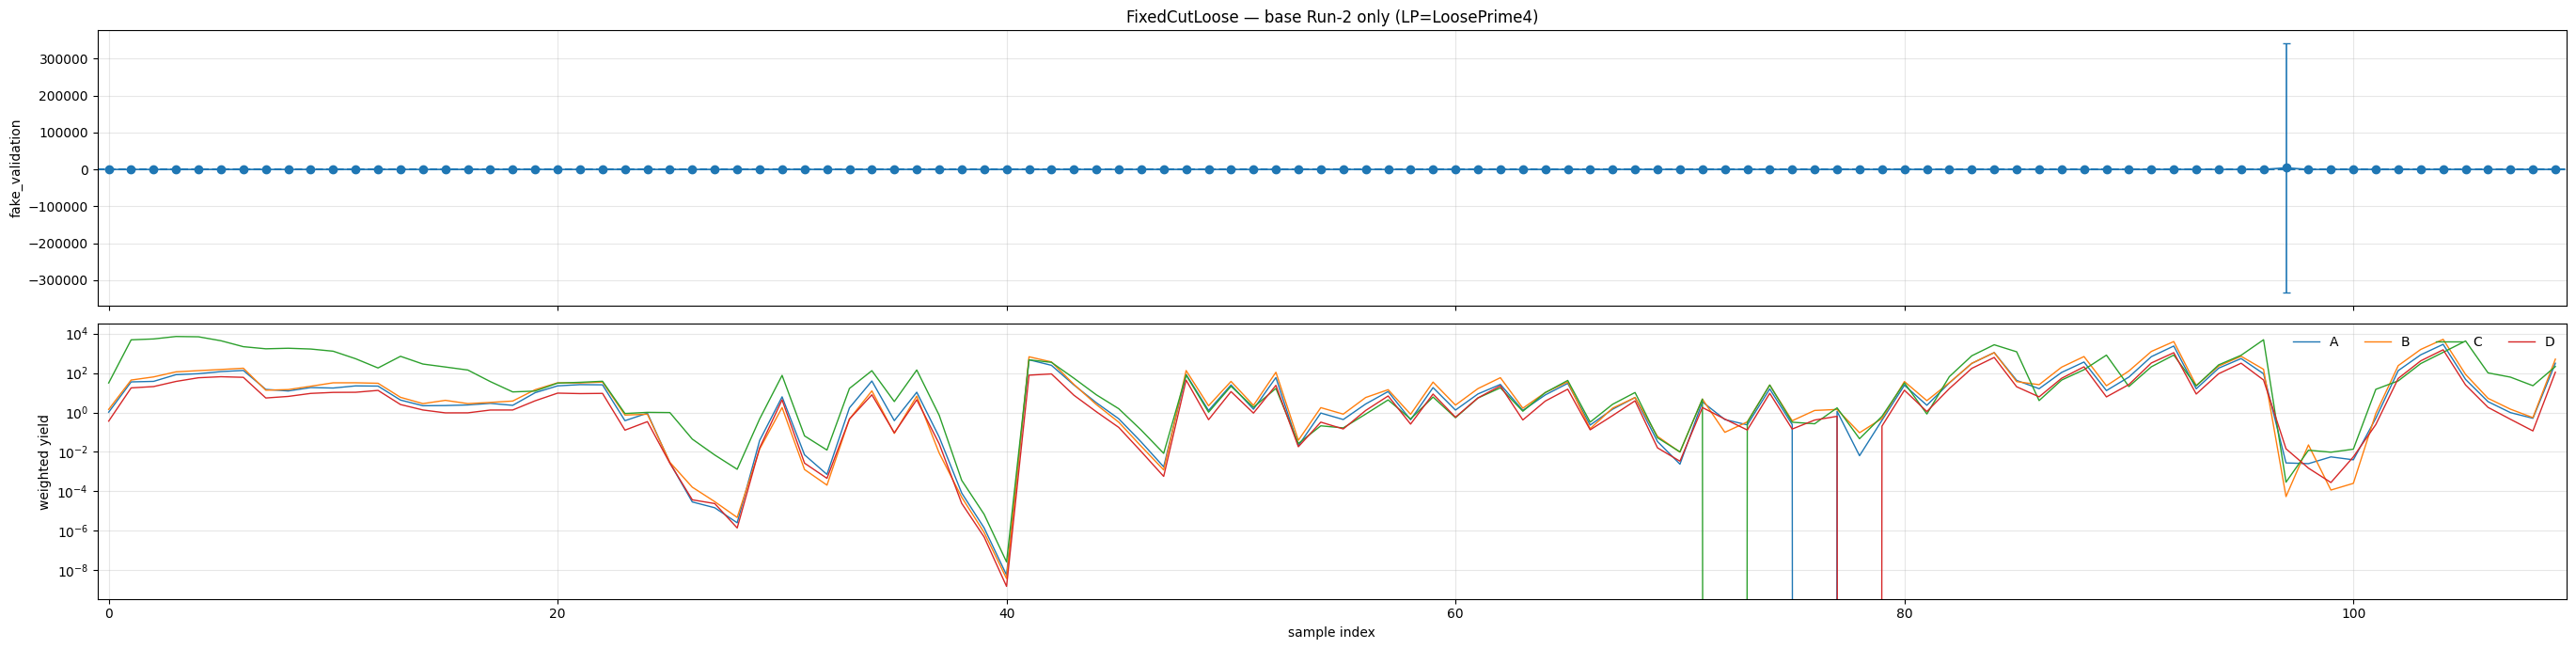

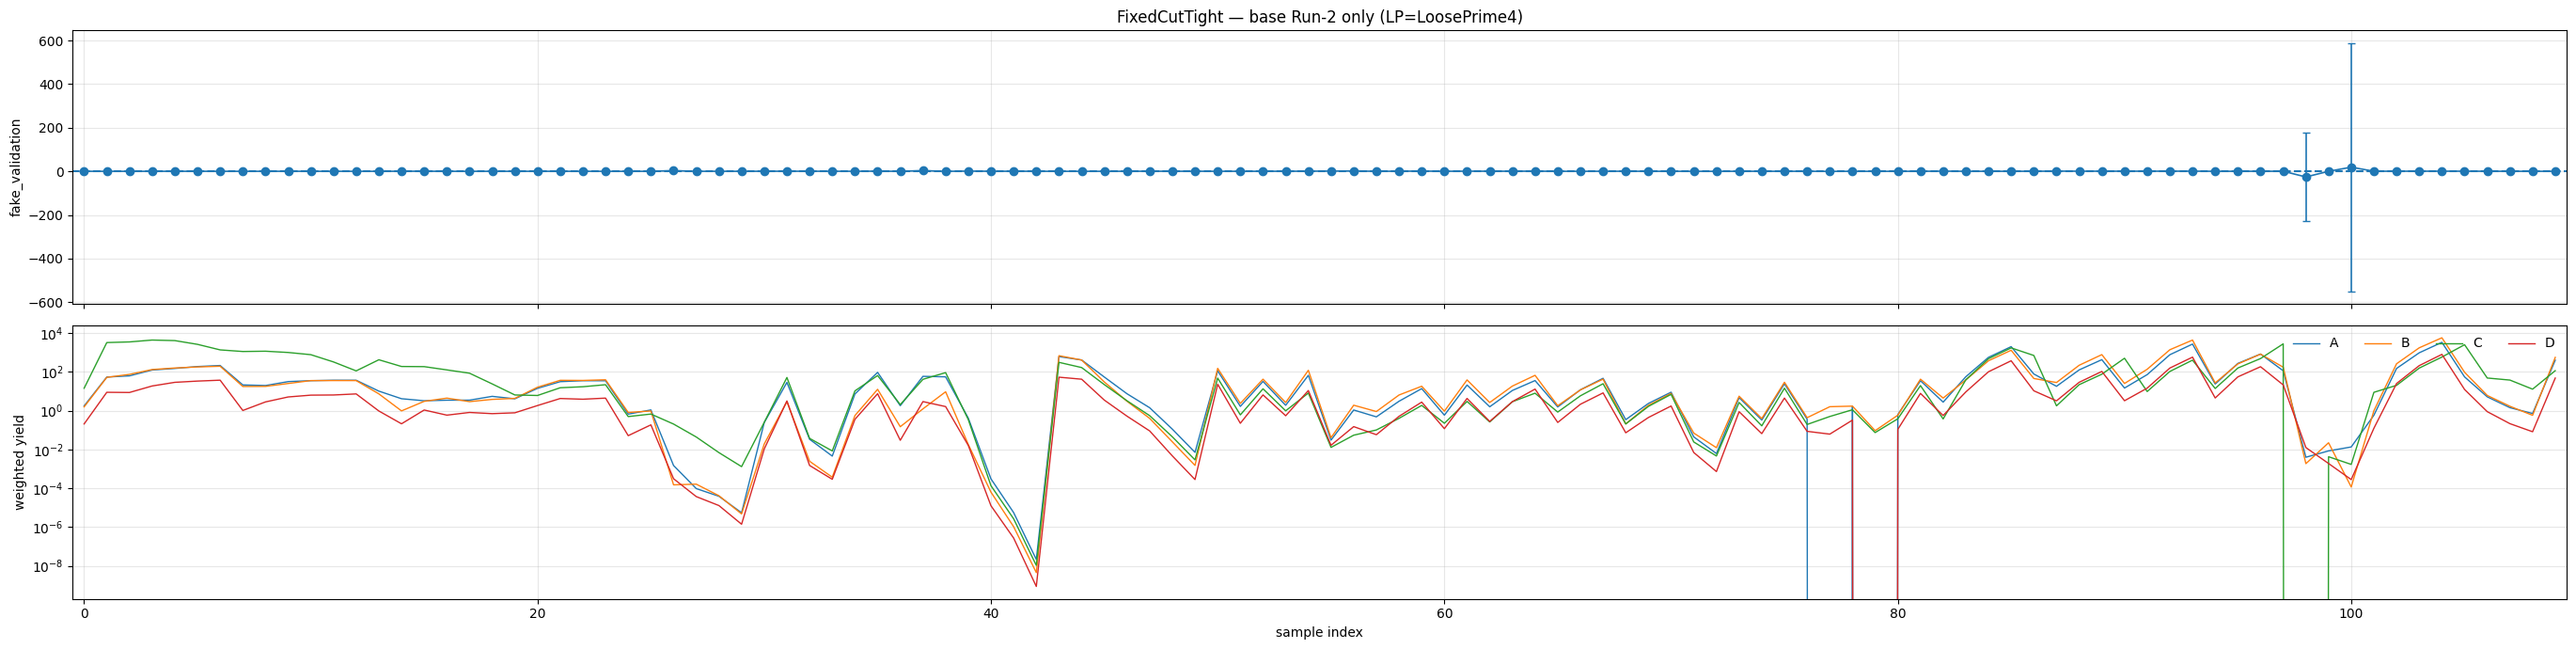

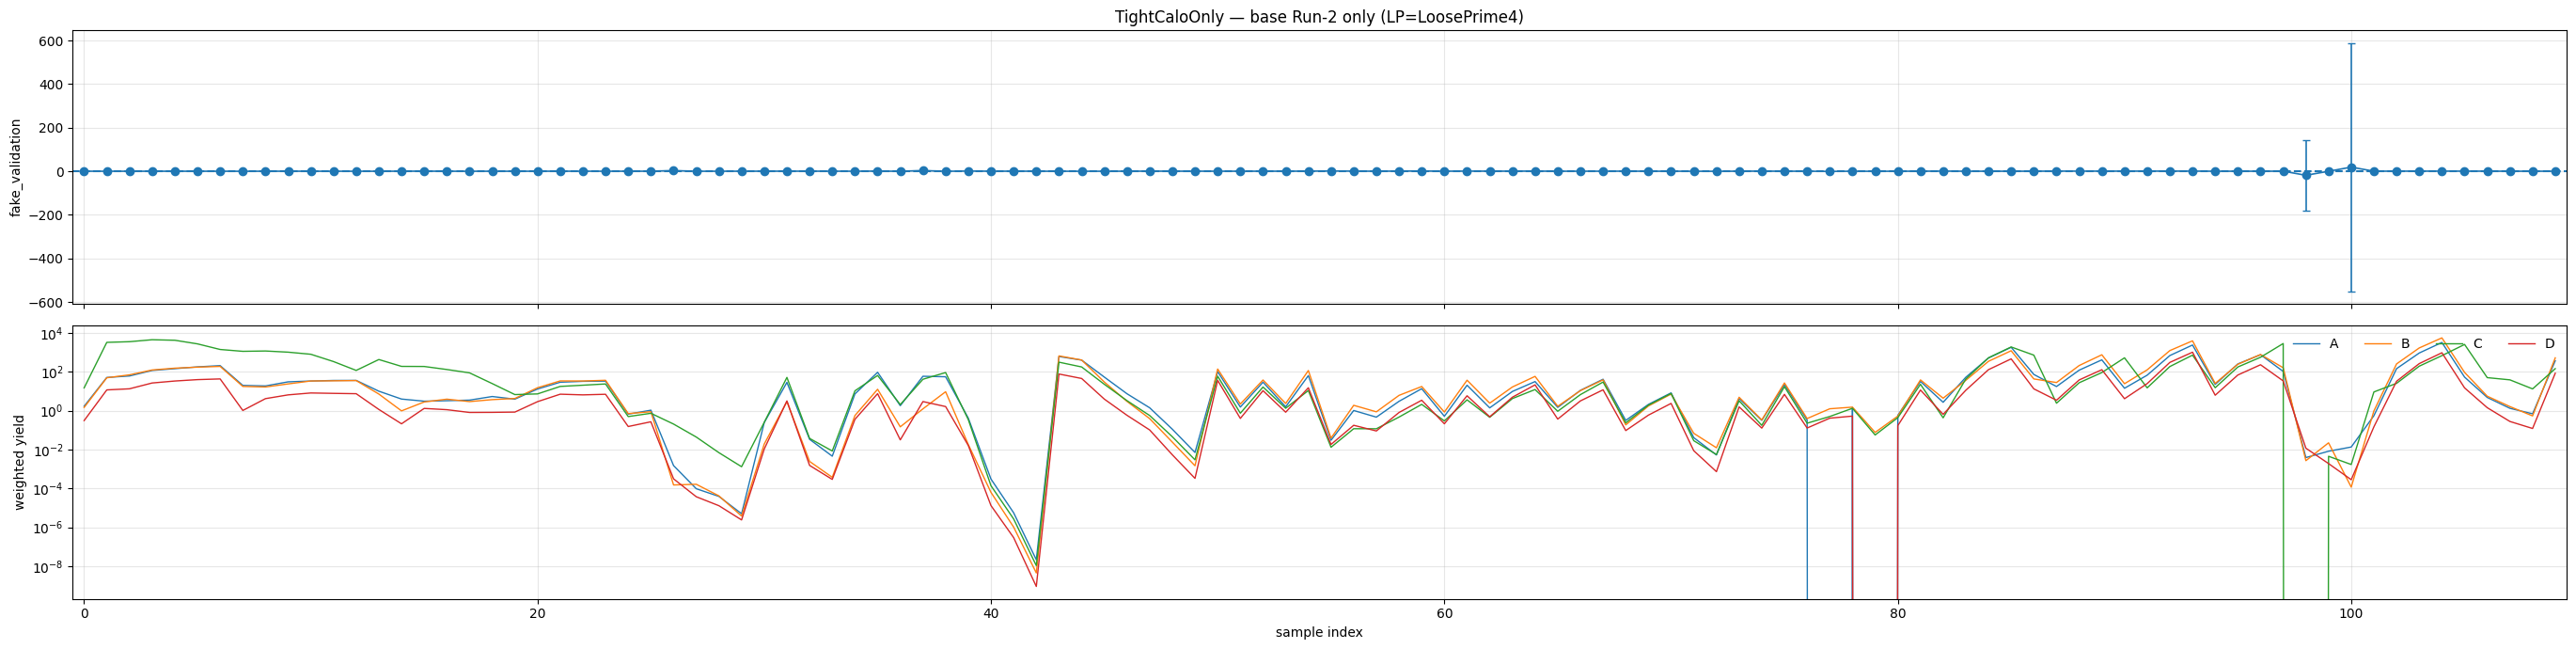

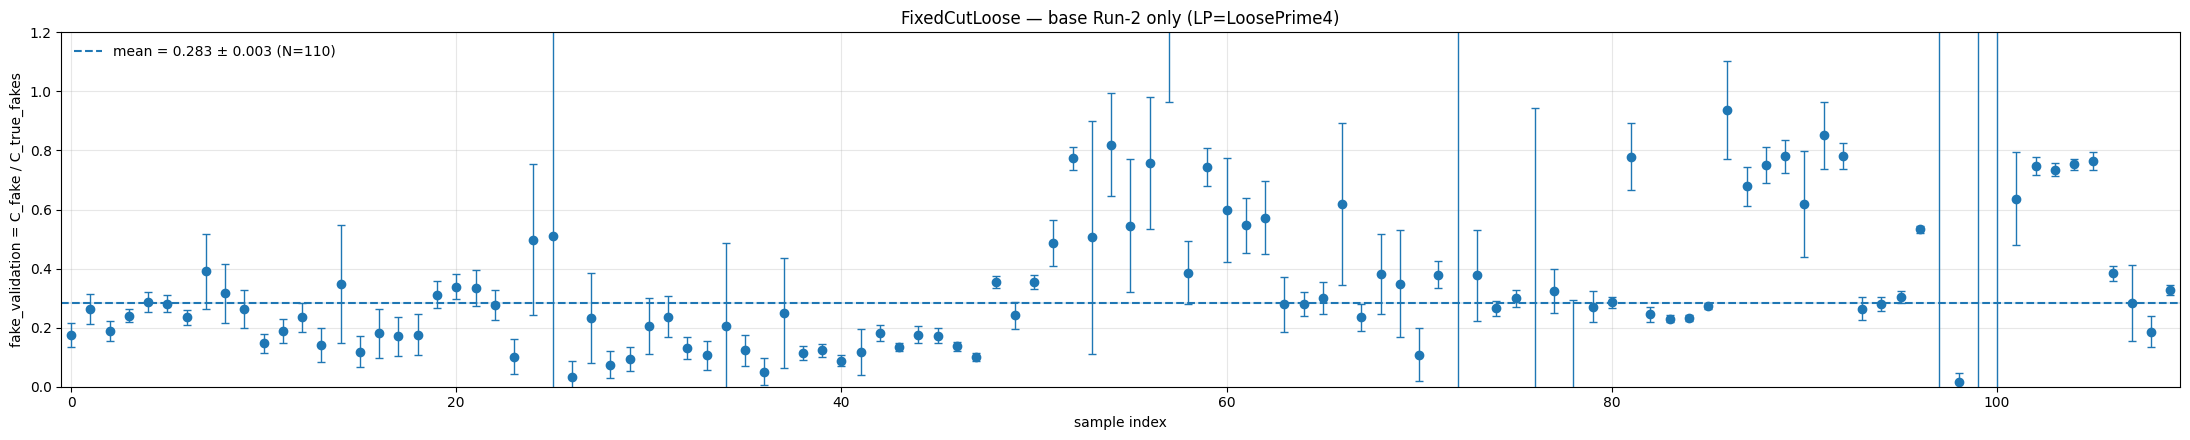

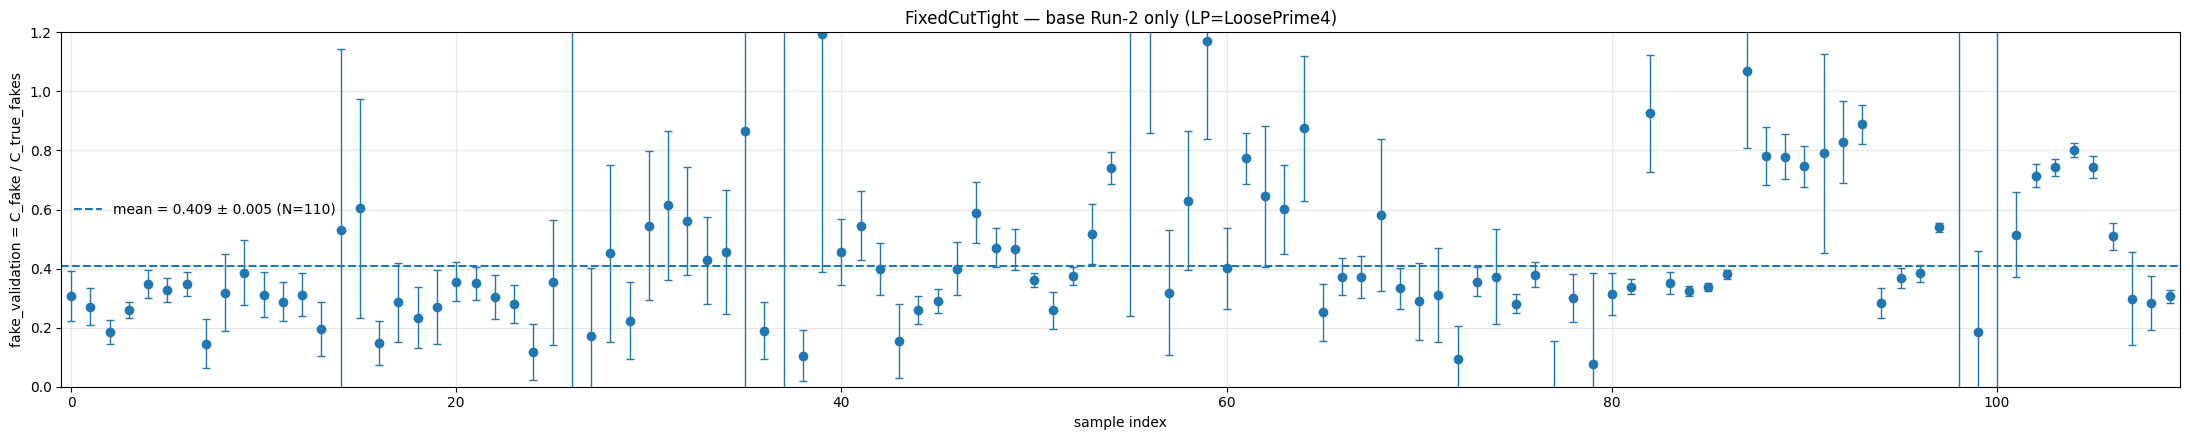

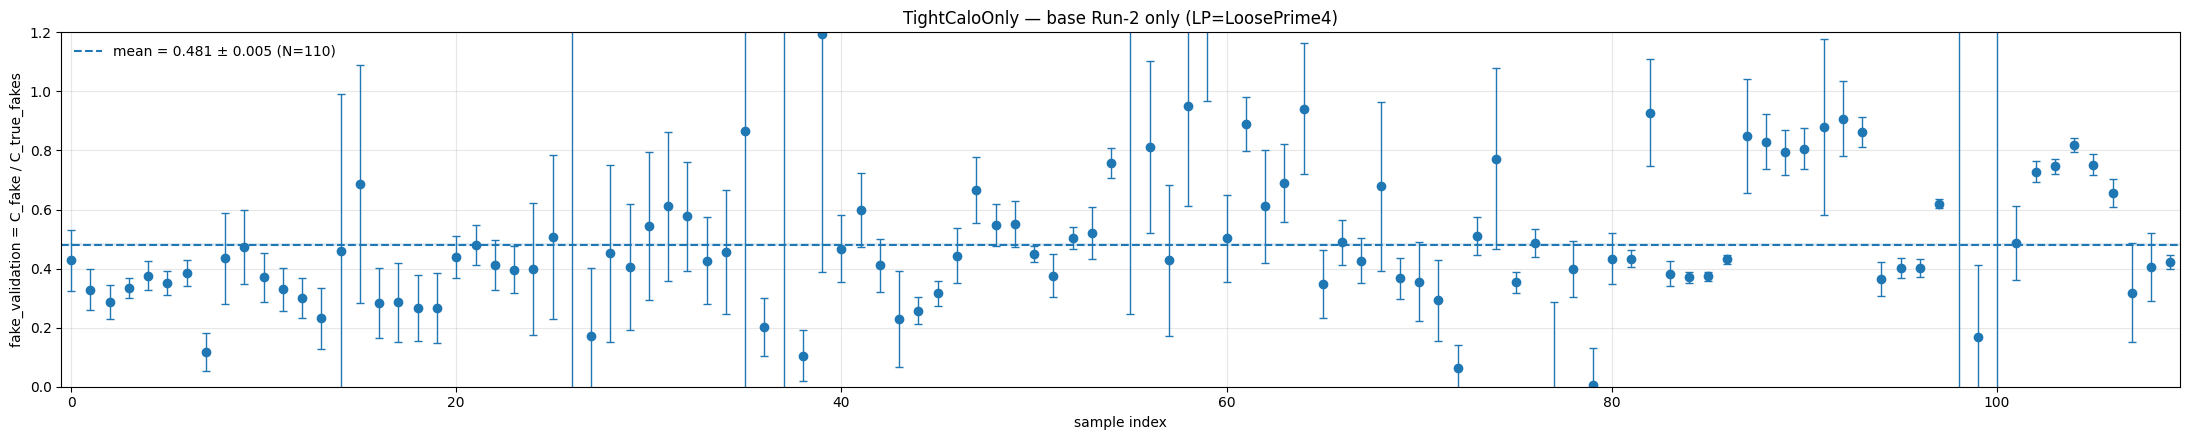

In [6]:
import os, re, glob, math
import numpy as np
import uproot
import matplotlib.pyplot as plt
from collections import defaultdict

# ---- 0) Where your files live ----
BASE_DIR = "/data/mhance/SUSY/ntuples/v3.1"

# ---- 1) Collect ONLY the *base* Run-2 files (exactly ..._mc20.root) ----
all_root = glob.glob(os.path.join(BASE_DIR, "*.root"))

def is_base_mc20(filename):
    """True for filenames that end with '_mc20.root' (no letter suffix)."""
    base = os.path.basename(filename)
    return re.search(r"_mc20\.root$", base) is not None

# (Optional) base Run-3 helper if you ever need it:
def is_base_mc23(filename):
    base = os.path.basename(filename)
    return re.search(r"_mc23\.root$", base) is not None

run2_files = sorted([p for p in all_root if is_base_mc20(p)])

print(f"Found {len(run2_files)} base Run-2 files (_mc20.root) in {BASE_DIR}")
for p in run2_files[:8]:
    print("  ", os.path.basename(p))
if len(run2_files) > 8:
    print("  ...")

# ---- 2) Choice of LoosePrime4
masks = build_looseprime_masks()
LP_CHOICE = "LoosePrime4"
lp_mask_bits = masks[LP_CHOICE]

# ---- 3) Branch list your abcd_counts expects ----
NEEDED_BRANCHES = [
    "ph_pt","ph_eta","ph_topoetcone20","ph_topoetcone40","ph_ptcone20",
    "ph_select_tightID","ph_truthprompt","ph_isEM",
    "met_met","jet_cleanTightBad_prod","j1_pt","mindPhiJetMet",
    "nBTagJets","nElectrons","nMuons","weight_total",
]

def load_arrays(FILE):
    with uproot.open(FILE) as f:
        arr = f["picontuple"].arrays(NEEDED_BRANCHES, library="np")
    return arr

def prepare_globals_for_file(arr):
    """Populate the module-level globals that abcd_counts() closes over."""
    global pt, eta, topo20, topo40, ptc20, tight, prompt, isEM, w
    global met_met, jet_cleanTightBad, j1_pt, mindPhiJetMet, nBTagJets, nElectrons, nMuons
    global TOT_mask

    # unpack
    pt      = arr["ph_pt"].astype(float)
    eta     = arr["ph_eta"].astype(float)
    topo20  = arr["ph_topoetcone20"].astype(float)
    topo40  = arr["ph_topoetcone40"].astype(float)
    ptc20   = arr["ph_ptcone20"].astype(float)
    tight   = (arr["ph_select_tightID"] == 1)
    prompt  = (arr["ph_truthprompt"]   == 1)
    isEM    = arr["ph_isEM"].astype(np.uint32)
    w       = arr["weight_total"].astype(float)

    met_met            = arr["met_met"].astype(float)
    jet_cleanTightBad  = arr["jet_cleanTightBad_prod"].astype(np.int32)
    j1_pt              = arr["j1_pt"].astype(float)
    mindPhiJetMet      = arr["mindPhiJetMet"].astype(float)
    nBTagJets          = arr["nBTagJets"].astype(np.int32)
    nElectrons         = arr["nElectrons"].astype(np.int32)
    nMuons             = arr["nMuons"].astype(np.int32)

    # baseline (TOTAL) mask
    abs_eta = np.abs(eta)
    eta_ok  = (abs_eta < 2.37) & ~((abs_eta > 1.37) & (abs_eta < 1.52))
    pt_ok   = (pt > 10_000.0)
    evt_ok  = (
        (met_met > 200_000.0) &
        (jet_cleanTightBad == 1) &
        (j1_pt > 150_000.0) &
        (mindPhiJetMet > 0.4) &
        (nBTagJets == 0) &
        (nElectrons == 0) &
        (nMuons == 0)
    )
    TOT_mask = eta_ok & pt_ok & evt_ok

def run_file(FILE):
    """Run ABCD on one file and return per-ISO (R, sR, A, B, C, D)."""
    arr = load_arrays(FILE)
    prepare_globals_for_file(arr)

    lp_pass = passes(lp_mask_bits, isEM)  # boolean array

    rows = []  # (iso_name, R, sR, A,B,C,D)
    for iso_name, iso_fun in [
        ("FixedCutLoose",  lambda: iso_mask_fixedcutloose(pt, topo20, ptc20)),
        ("FixedCutTight",  lambda: iso_mask_fixedcuttight(pt, topo40, ptc20)),
        ("TightCaloOnly",  lambda: iso_mask_tightcaloonly(pt, topo40)),
    ]:
        iso = iso_fun()
        # abcd_counts returns: A,B,C,D,C_fake,purity,realPurity,totalFakes,errs
        A,B,C,D,C_fake,purity,realPurity,totalFakes,errs = abcd_counts(iso, lp_pass)
        R  = errs.get("fake_validation", np.nan)   # = C_fake / totalFakes
        sR = errs.get("sFakeValidation", np.nan)   # stat uncertainty on that ratio
        rows.append((iso_name, R, sR, A, B, C, D))
    return rows

# ---- 4) Loop over base Run-2 files: print per-sample, accumulate mean, collect for plots ----
accum = defaultdict(lambda: {"num":0.0,"den":0.0,"N":0})

# For plots (no filenames; just sequences)
per_iso = defaultdict(lambda: {"R": [], "sR": []})            # fake_validation points
per_iso_counts = defaultdict(lambda: {"A": [], "B": [], "C": [], "D": []})  # weighted yields

for path in run2_files:
    tag = os.path.basename(path).replace("output_","").replace(".root","")
    try:
        rows = run_file(path)  # -> list of (iso_name, R, sR, A,B,C,D)
    except Exception as e:
        print(f"[SKIP] {tag}: {e}")
        continue

    print(f"\n=== {tag} | LP={LP_CHOICE} ===")
    for iso_name, R, sR, A, B, C, D in rows:
        if (R is not None and sR is not None and np.isfinite(R) and np.isfinite(sR) and sR > 0.0):
            print(f"{iso_name:14s} fake_validation = {R:7.3f} ± {sR:7.3f}")
            w_invvar = 1.0 / (sR**2)
            accum[iso_name]["num"] += R * w_invvar
            accum[iso_name]["den"] += w_invvar
            accum[iso_name]["N"]   += 1

            # collect for plots
            per_iso[iso_name]["R"].append(float(R))
            per_iso[iso_name]["sR"].append(float(sR))
            per_iso_counts[iso_name]["A"].append(float(A))
            per_iso_counts[iso_name]["B"].append(float(B))
            per_iso_counts[iso_name]["C"].append(float(C))
            per_iso_counts[iso_name]["D"].append(float(D))
        else:
            print(f"{iso_name:14s} fake_validation = NaN (excluded)")

print("\n=== Combined over base Run-2 samples (inverse-variance) ===")
means = {}
for iso_name in ["FixedCutLoose","FixedCutTight","TightCaloOnly"]:
    num = accum[iso_name]["num"]; den = accum[iso_name]["den"]; N = accum[iso_name]["N"]
    if den > 0:
        Rbar  = num/den
        sRbar = 1.0/math.sqrt(den)
        means[iso_name] = (Rbar, sRbar, N)
        print(f"{iso_name:14s} mean fake_validation = {Rbar:7.3f} ± {sRbar:7.3f}  (N={N})")
    else:
        means[iso_name] = (np.nan, np.nan, 0)
        print(f"{iso_name:14s} mean fake_validation = NaN (no finite inputs)")

# ---- 5) PLOTS: per-ISO curves (index on x-axis), no filenames ----
for iso_name in ["FixedCutLoose","FixedCutTight","TightCaloOnly"]:
    R  = np.array(per_iso[iso_name]["R"], dtype=float)
    sR = np.array(per_iso[iso_name]["sR"], dtype=float)

    A = np.array(per_iso_counts[iso_name]["A"], dtype=float)
    B = np.array(per_iso_counts[iso_name]["B"], dtype=float)
    C = np.array(per_iso_counts[iso_name]["C"], dtype=float)
    D = np.array(per_iso_counts[iso_name]["D"], dtype=float)

    n = len(R)
    if n == 0:
        print(f"[PLOT] {iso_name}: no valid points to plot.")
        continue

    x = np.arange(n)  # 0..n-1
    Rbar, sRbar, N = means[iso_name]

    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(max(8, n*0.25), 7), sharex=True,
        gridspec_kw={"height_ratios":[2,2]}
    )

    # Top: fake_validation curve (with error bars) + weighted mean
    ax1.errorbar(x, R, yerr=sR, fmt="-o", linewidth=1.2, capsize=3)
    if np.isfinite(Rbar) and np.isfinite(sRbar) and N > 0:
        ax1.axhline(Rbar, linestyle="--", linewidth=1.5, label=f"mean {Rbar:.3f} ± {sRbar:.3f}")
        ax1.fill_between([-0.5, n-0.5], Rbar - sRbar, Rbar + sRbar, alpha=0.15, step="pre")
    ax1.set_ylabel("fake_validation")
    ax1.grid(alpha=0.3)
    ax1.set_title(f"{iso_name} — base Run-2 only (LP={LP_CHOICE})")

    # Bottom: counts A/B/C/D (weighted yields)
    ax2.plot(x, A, "-", linewidth=1.0, label="A")
    ax2.plot(x, B, "-", linewidth=1.0, label="B")
    ax2.plot(x, C, "-", linewidth=1.0, label="C")
    ax2.plot(x, D, "-", linewidth=1.0, label="D")
    ax2.set_yscale("log")
    ax2.set_ylabel("weighted yield")
    ax2.set_xlabel("sample index")
    ax2.grid(alpha=0.3)
    ax2.legend(frameon=False, ncol=4, loc="upper right")

    ax1.set_xlim(-0.5, n-0.5)
    ax2.set_xlim(-0.5, n-0.5)

    plt.tight_layout()
    # plt.savefig(f"curves_{iso_name}_mc20_base.png", dpi=150)


isos = ["FixedCutLoose", "FixedCutTight", "TightCaloOnly"]

for iso_name in isos:
    R  = np.array(per_iso[iso_name]["R"], dtype=float)
    sR = np.array(per_iso[iso_name]["sR"], dtype=float)

    if R.size == 0:
        print(f"[PLOT] {iso_name}: no valid fake_validation points.")
        continue

    # x-axis = sample index (no file names)
    x = np.arange(R.size)

    # pull weighted mean and its stat error that you already computed
    Rbar, sRbar, N = means.get(iso_name, (np.nan, np.nan, 0))

    plt.figure(figsize=(max(6, R.size * 0.2), 4.5))

    # scatter with vertical error bars
    plt.errorbar(x, R, yerr=sR, fmt="o", capsize=3, linewidth=1.0)

    # overlay weighted mean ±1σ
    if np.isfinite(Rbar) and np.isfinite(sRbar) and N > 0:
        plt.axhline(Rbar, linestyle="--", linewidth=1.5, label=f"mean = {Rbar:.3f} ± {sRbar:.3f} (N={N})")
        plt.fill_between([-0.5, R.size - 0.5], Rbar - sRbar, Rbar + sRbar, alpha=0.15, step="pre")

    plt.xlim(-0.5, R.size - 0.5)
    # choose sensible y-range; your values are ~0.15–0.45 right now
    ymin = max(0.0, np.nanmin(R - sR) - 0.05)
    ymax = min(1.2,  np.nanmax(R + sR) + 0.05)
    plt.ylim(ymin, ymax)

    plt.xlabel("sample index")
    plt.ylabel("fake_validation = C_fake / C_true_fakes")
    plt.title(f"{iso_name} — base Run-2 only (LP={LP_CHOICE})")
    plt.grid(alpha=0.3)
    plt.legend(frameon=False)

    plt.tight_layout()


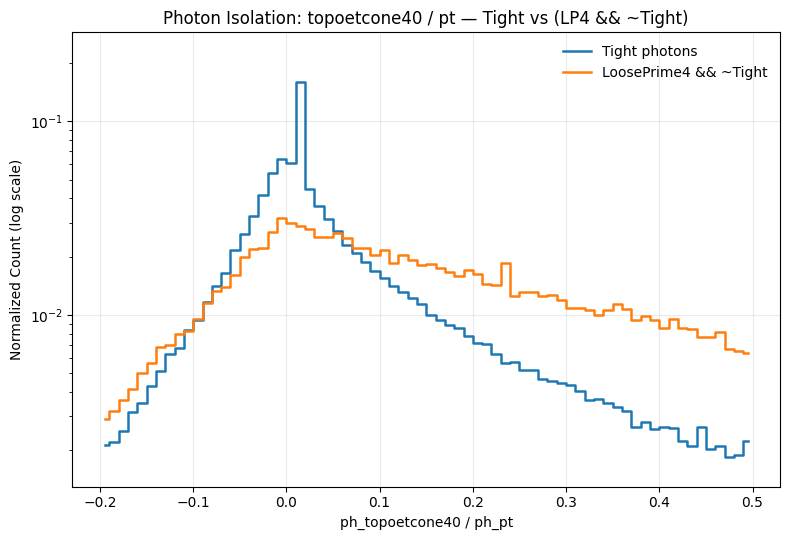

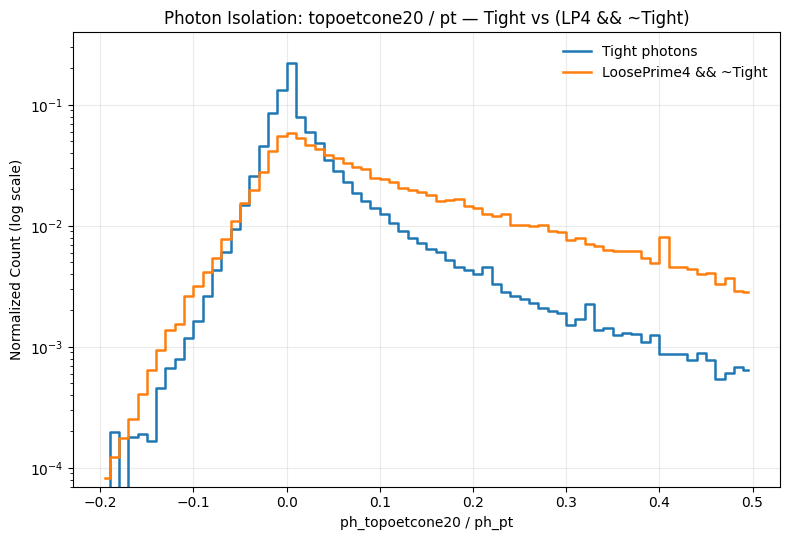

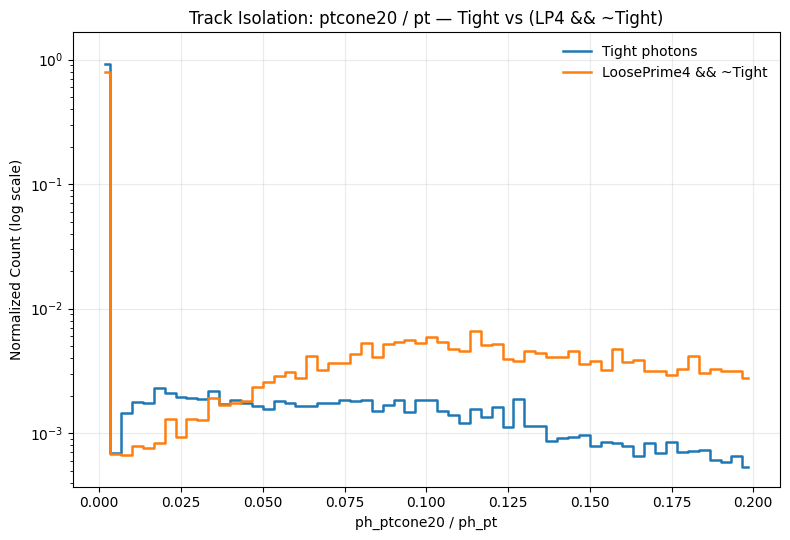

In [7]:
# =======================
# Isolation-shape plots (weighted, normalized)
#   • topoetcone40 / pt
#   • topoetcone20 / pt
#   • ptcone20     / pt
# for:
#   Tight  vs  (LoosePrime3 && ~Tight)
# =======================
import numpy as np
import matplotlib.pyplot as plt

LP4_BITS = masks["LoosePrime4"]   # control selection

# binning (tweak if you want)
bins_40 = np.linspace(-0.20, 0.50, 71)   # 70 bins
bins_20 = np.linspace(-0.20, 0.50, 71)
bins_pt = np.linspace( 0.00, 0.20, 61)   # track iso is ≥0, usually small

# running hist sums across ALL base Run-2 files
H40_tight = np.zeros(len(bins_40)-1);  H40_lp3nt = np.zeros_like(H40_tight)
H20_tight = np.zeros(len(bins_20)-1);  H20_lp3nt = np.zeros_like(H20_tight)
Hpt_tight = np.zeros(len(bins_pt)-1);  Hpt_lp3nt = np.zeros_like(Hpt_tight)

def safe_hist(values, weights, bins):
    m = np.isfinite(values) & np.isfinite(weights)
    h, _ = np.histogram(values[m], bins=bins, weights=weights[m])
    return h

for path in run2_files:
    try:
        arr = load_arrays(path)
        prepare_globals_for_file(arr)
    except Exception as e:
        print(f"[ISO PLOT | SKIP] {os.path.basename(path)}: {e}")
        continue

    base      = TOT_mask
    sel_tight = base &  tight
    sel_lp3nt = base & ~tight & passes(LP4_BITS, isEM)

    # isolation variables (guard against pt=0)
    denom = np.where(pt != 0.0, pt, np.inf)
    iso40 = topo40 / denom
    iso20 = topo20 / denom
    isoPT = ptc20  / denom

    # weights applied via boolean masks
    w_tight  = w * sel_tight
    w_lp3nt  = w * sel_lp3nt

    H40_tight += safe_hist(iso40, w_tight, bins_40)
    H40_lp3nt += safe_hist(iso40, w_lp3nt, bins_40)

    H20_tight += safe_hist(iso20, w_tight, bins_20)
    H20_lp3nt += safe_hist(iso20, w_lp3nt, bins_20)

    Hpt_tight += safe_hist(isoPT, w_tight, bins_pt)
    Hpt_lp3nt += safe_hist(isoPT, w_lp3nt, bins_pt)

def norm_or_zero(h):
    s = h.sum()
    return (h / s) if s > 0 else h

def plot_two_steps(bins, H_tight, H_lp3nt, xlabel, title):
    Ht = norm_or_zero(H_tight)
    Hl = norm_or_zero(H_lp3nt)
    centers = 0.5*(bins[1:]+bins[:-1])

    plt.figure(figsize=(8, 5.5))
    plt.step(centers, Ht, where="mid", linewidth=1.8, label="Tight photons")
    plt.step(centers, Hl, where="mid", linewidth=1.8, label="LoosePrime4 && ~Tight")

    plt.yscale("log")
    # tidy y-lims even if some bins are empty
    ymin = 1e-4
    if (Ht>0).any() or (Hl>0).any():
        mins = [Ht[Ht>0].min() if (Ht>0).any() else np.inf,
                Hl[Hl>0].min() if (Hl>0).any() else np.inf]
        ymin = max(1e-4, min(mins))
    plt.ylim(ymin*0.7, max(Ht.max(), Hl.max())*1.8)

    plt.xlabel(xlabel)
    plt.ylabel("Normalized Count (log scale)")
    plt.title(title)
    plt.grid(alpha=0.25)
    plt.legend(frameon=False)
    plt.tight_layout()
    # plt.savefig(title.replace(" ","_")+".png", dpi=150)

# --- make the three figures ---
plot_two_steps(
    bins_40, H40_tight, H40_lp3nt,
    xlabel="ph_topoetcone40 / ph_pt",
    title="Photon Isolation: topoetcone40 / pt — Tight vs (LP4 && ~Tight)"
)
plot_two_steps(
    bins_20, H20_tight, H20_lp3nt,
    xlabel="ph_topoetcone20 / ph_pt",
    title="Photon Isolation: topoetcone20 / pt — Tight vs (LP4 && ~Tight)"
)
plot_two_steps(
    bins_pt, Hpt_tight, Hpt_lp3nt,
    xlabel="ph_ptcone20 / ph_pt",
    title="Track Isolation: ptcone20 / pt — Tight vs (LP4 && ~Tight)"
)


In [10]:
# --- make sure this branch is included when loading ---
# (add once to your NEEDED_BRANCHES list near the top of your script)
# NEEDED_BRANCHES += ["ph_select_hybridCaloIso"]

# --- build all LoosePrime masks ---
masks = build_looseprime_masks()

print("Masks (hex):")
for k, m in masks.items():
    print(f"  {k:>18}: {hex(int(m))}")



# --- build hybrid isolation pass directly from the branch ---
hybridIso = (arr["ph_select_hybridCOIso"] == 1)

LP4_BITS = masks["LoosePrime4"]


lp_pass = passes(LP4_BITS, isEM)
results = abcd_counts(hybridIso, lp_pass)

pretty_print(f"LoosePrime4 | HybridCaloIso", *results)


Masks (hex):
         LoosePrime2: 0x27dc00
         LoosePrime3: 0x25dc00
         LoosePrime4: 0x5dc00
        LoosePrime4a: 0x21dc00
         LoosePrime5: 0x1dc00
                Run1: 0x45fc01

=== LoosePrime4 | HybridCaloIso ===
A (tight & !Iso; bg-only): 2367.454  ± 26.635
B (!tight & !Iso; bg-only): 4286.566  ± 36.359
C (tight &  Iso; total)  : 1597.832  ± 20.787
D (!tight &  Iso; bg-only): 2313.120  ± 25.200
---
C_fake (pred) = 1277.527 ± 22.753
True fakes in C (weighted) = 1595.734 ± 20.776
Ratio of Fakes (pred/true) = 0.801 ± 0.018
Purity (C_real / C) = 0.2005 ± 0.0176
Actual purity from truth = 0.0013

